In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid', 'property_address_school_transactions']


In [62]:
df_transaction = ds.get_view_df('property_address_school_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1515306, 37)
(709325, 22)


In [63]:
pp = Preprocess(df_transaction, df_property)

In [64]:
use_features = pp.get_feature_list()

In [65]:
# records of last year
#use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, clean=True, date=('2015-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(67336, 24)

In [66]:
df_track.head()

,num_bed,id,date,middle_rating,avg_middle_rating,pool,lat,min_high_distance,avg_high_rating,zip,...,num_bath,high_rating,sqft,lon,impr_over_land,sqft_zip_avg,min_elem_distance,min_middle_distance,sqft_price_zip_avg,elem_rating
0,4.0,1431199,2015-10-01,9.0,9.0,1,33.09614,2535.994887,9.0,92009,...,4.0,9.0,3511,-117.22771,0.903509,2395.391515,1495.337965,4743.713874,325.947368,9.0
8847,4.0,1431252,2015-10-01,NaN,NaN,0,33.10266,NaN,NaN,92011,...,3.0,NaN,2456,-117.30830,0.889355,2168.720329,NaN,NaN,386.998825,NaN
8846,4.0,1431205,2015-10-01,NaN,NaN,0,33.11431,NaN,NaN,92011,...,2.0,NaN,1645,-117.29709,0.773644,2168.720329,NaN,NaN,386.998825,NaN
25639,3.0,1431225,2015-10-01,6.0,6.0,0,32.57141,588.900513,5.0,91932,...,2.0,5.0,1008,-117.10905,1.225000,1313.214634,283.480311,1252.112571,368.580488,5.0
25640,3.0,1431226,2015-10-01,6.0,6.0,0,32.58091,685.538099,5.0,91932,...,2.0,5.0,1773,-117.12991,5.653498,1313.214634,1001.811843,746.714487,368.580488,6.0


In [67]:
df_track.isnull().sum()

num_bed                   0
id                        0
date                      0
middle_rating          5800
avg_middle_rating      5684
pool                      0
lat                       0
min_high_distance      7777
avg_high_rating        7661
zip                       0
avg_elem_rating        2441
sold_price_zip_avg        0
sold_price                0
view                      0
num_bath                  0
high_rating            7799
sqft                      0
lon                       0
impr_over_land            0
sqft_zip_avg              0
min_elem_distance      2430
min_middle_distance    4411
sqft_price_zip_avg        0
elem_rating            2441
dtype: int64

### baseline without segment

In [68]:
#df_track_valid = df_track.fillna(df_track.mean())
df_track_valid = df_track[np.isfinite(df_track['min_elem_distance']) & 
                          np.isfinite(df_track['min_middle_distance']) &
                          np.isfinite(df_track['min_high_distance']) &
                          np.isfinite(df_track['elem_rating']) &
                          np.isfinite(df_track['middle_rating']) &
                          np.isfinite(df_track['high_rating']) 
                         ]

In [69]:
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
print(df_track_valid.shape)
monthly_volume = int(df_track_valid.shape[0] / 24)
mm = ModelManager(df_track_valid, use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 47641, 28584, 9528
[dp] train/valid/test size: 38112, 9529, 9528
[dp] validation step is skipped


(57169, 24)


104595.71533250101

### segment on sold_price
* segment on sold_price is only for experiment, not practical in real case
* 2 segments: <1M, >=1M
* random forest

In [59]:
# < 1M
rf = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=17)
df_track_filter = df_track_valid[df_track_valid['sold_price']<1000000]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm1 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm1.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 44089, 26448, 8816
[dp] train/valid/test size: 35271, 8818, 8816
[dp] validation step is skipped


(52905, 24)


71278.0848068714

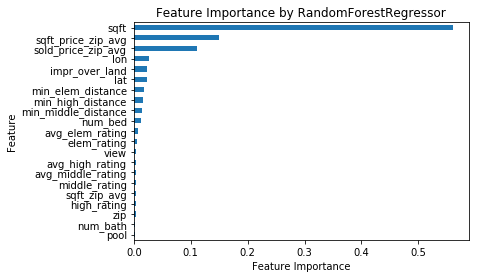

In [61]:
mm1.plot_feature_importance()

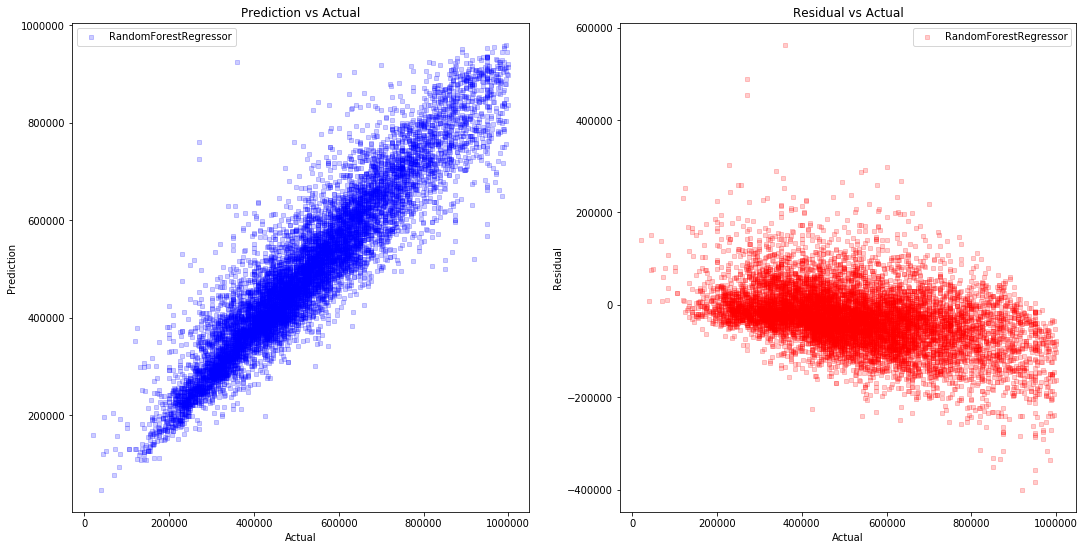

In [16]:
mm1.plot_residual()

In [13]:
# >= 1M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[df_track['sold_price']>=1000000]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm2 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm2.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 4578, 2736, 912
[dp] train/valid/test size: 3662, 916, 912
[dp] validation step is skipped


(5490, 17)


233286.10164586114

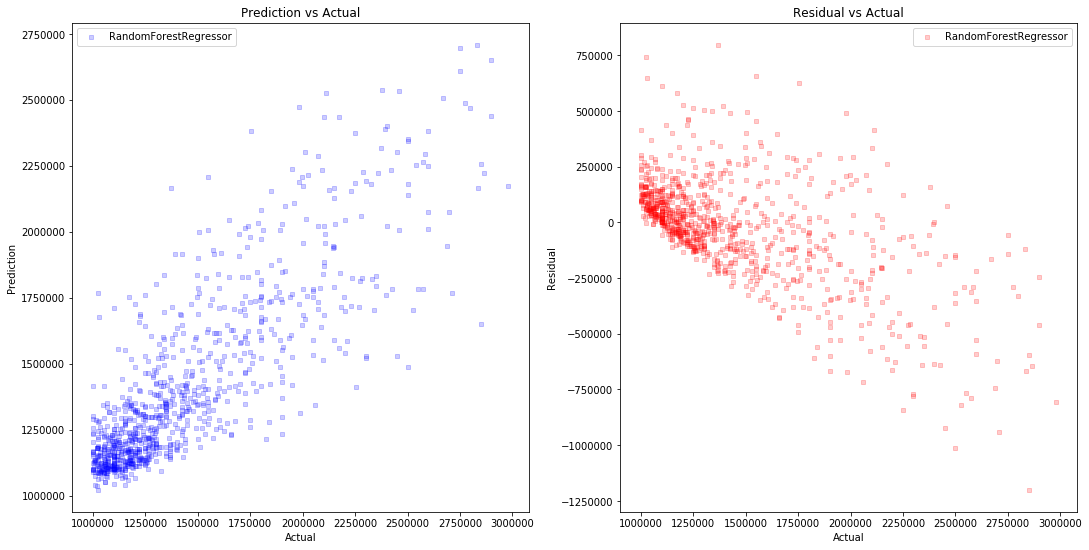

In [14]:
mm2.plot_residual()

In [15]:
def remeasure(df_checks):
    df_merged = pd.concat(df_checks)
    print(df_merged.shape)
    return sqrt(mean_squared_error(df_merged['predict'], df_merged['sold_price']))

df_check1 = mm1.get_result_df()
df_check2 = mm2.get_result_df()
remeasure([df_check1, df_check2])

(11092, 19)


96040.74227425546

In [16]:
### 3 segments
# < 0.6M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[df_track['sold_price']<600000]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm1 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm1.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

# .6M ~ 1M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[(df_track['sold_price']>=600000)&(df_track['sold_price']<1000000)]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm2 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm2.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

# >= 1M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[df_track['sold_price']>=1000000]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm3 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm3.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

df_check1 = mm1.get_result_df()
df_check2 = mm2.get_result_df()
df_check3 = mm3.get_result_df()
remeasure([df_check1, df_check2, df_check3])

[dp] track/sliding/test window size: 37560, 22524, 7508
[dp] train/valid/test size: 30048, 7512, 7508
[dp] validation step is skipped


(45068, 17)


[dp] track/sliding/test window size: 13360, 8016, 2672
[dp] train/valid/test size: 10688, 2672, 2672
[dp] validation step is skipped


(16032, 17)


[dp] track/sliding/test window size: 4578, 2736, 912
[dp] train/valid/test size: 3662, 916, 912
[dp] validation step is skipped


(5490, 17)
(11092, 19)


87482.38568119476